# 문서 이미지 분류 - 탐색적 데이터 분석(EDA)

이 노트북은 문서 이미지 데이터셋에 대한 철저한 탐색적 데이터 분석을 수행합니다.

**분석 목표:**
1. 데이터셋의 기본 구조와 클래스 분포를 이해합니다.
2. 이미지의 시각적 특성(크기, 종횡비, 채널 등)을 분석합니다.
3. 각 클래스별 이미지 샘플을 시각화하여 정성적 인사이트를 얻습니다.
4. 문서 이미지에 적합한 데이터 증강 기법을 탐색합니다.
5. 클래스 간 유사성을 분석하여 모델이 혼동할 수 있는 클래스를 파악합니다.

## 1. Setup and Library Imports

In [6]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

# Add project root to path for imports
sys.path.append('..')
import project_setup
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font family to NanumGothic
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

# Set the default style for seaborn plots
sns.set_theme(style="whitegrid", font="NanumGothic", font_scale=1.1, rc={'axes.unicode_minus': False}
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [7]:
DATASET_PATH = project_setup.PROJECT_ROOT / "data" / "raw"
TRAIN_CSV = DATASET_PATH / "metadata" / "train.csv"
META_CSV = DATASET_PATH / "metadata" / "meta.csv"
SAMPLE_SUBMISSION_CSV = project_setup.PROJECT_ROOT / "data" / "dataset" / "sample_submission.csv"


dataset_path = Path(DATASET_PATH)
train_images_path = dataset_path / "train"
test_images_path = dataset_path / "test"
train_images_path = DATASET_PATH / "train"

print(f"Dataset path: {DATASET_PATH} - {'✅' if DATASET_PATH.exists() else '❌'}")
print(f"Train images: {train_images_path} - {'✅' if train_images_path.exists() else '❌'}")
print(f"Test images: {test_images_path} - {'✅' if test_images_path.exists() else '❌'}")
print(f"Train CSV: {TRAIN_CSV} - {'✅' if TRAIN_CSV.exists() else '❌'}")
print(f"Meta CSV: {META_CSV} - {'✅' if META_CSV.exists() else '❌'}")



Dataset path: /home/wb2x/projects/ml-projects/document-classifier/data/raw - ✅
Train images: /home/wb2x/projects/ml-projects/document-classifier/data/raw/train - ✅
Test images: /home/wb2x/projects/ml-projects/document-classifier/data/raw/test - ✅
Train CSV: /home/wb2x/projects/ml-projects/document-classifier/data/raw/metadata/train.csv - ✅
Meta CSV: /home/wb2x/projects/ml-projects/document-classifier/data/raw/metadata/meta.csv - ✅


## 2. Dataset Path and Basic Info

In [8]:
DATASET_PATH = project_setup.PROJECT_ROOT / "data" / "raw"
TRAIN_CSV = DATASET_PATH / "metadata" / "train.csv"
META_CSV = DATASET_PATH / "metadata" / "meta.csv"
SAMPLE_SUBMISSION_CSV = project_setup.PROJECT_ROOT / "data" / "dataset" / "sample_submission.csv"

dataset_path = Path(DATASET_PATH)
train_images_path = dataset_path / "train"
test_images_path = dataset_path / "test"
train_images_path = DATASET_PATH / "train"

print(f"Dataset path: {DATASET_PATH} - {'✅' if DATASET_PATH.exists() else '❌'}")
print(f"Train images: {train_images_path} - {'✅' if train_images_path.exists() else '❌'}")
print(f"Test images: {test_images_path} - {'✅' if test_images_path.exists() else '❌'}")
print(f"Train CSV: {TRAIN_CSV} - {'✅' if TRAIN_CSV.exists() else '❌'}")
print(f"Meta CSV: {META_CSV} - {'✅' if META_CSV.exists() else '❌'}")


Dataset path: /home/wb2x/projects/ml-projects/document-classifier/data/raw - ✅
Train images: /home/wb2x/projects/ml-projects/document-classifier/data/raw/train - ✅
Test images: /home/wb2x/projects/ml-projects/document-classifier/data/raw/test - ✅
Train CSV: /home/wb2x/projects/ml-projects/document-classifier/data/raw/metadata/train.csv - ✅
Meta CSV: /home/wb2x/projects/ml-projects/document-classifier/data/raw/metadata/meta.csv - ✅


In [9]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
meta_df = pd.read_csv(META_CSV)

print("📊 Train CSV Info:")
print(f"Shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")
print("\nFirst 5 rows:")
display(train_df.head())

print("\n📋 Meta CSV Info:")
print(f"Shape: {meta_df.shape}")
print(f"Columns: {meta_df.columns.tolist()}")
print("\nFirst 5 rows:")
display(meta_df.head())

📊 Train CSV Info:
Shape: (1570, 2)
Columns: ['ID', 'target']

First 5 rows:


ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16


📋 Meta CSV Info:
Shape: (17, 2)
Columns: ['target', 'class_name']

First 5 rows:


target                                         class_name
0       0                                     account_number
1       1  application_for_payment_of_pregnancy_medical_e...
2       2                                      car_dashboard
3       3            confirmation_of_admission_and_discharge
4       4                                          diagnosis

In [10]:
# 클래스 매핑 생성 및 train_df에 클래스 이름 추가
target_to_class = dict(zip(meta_df['target'], meta_df['class_name']))  # target 번호 → 클래스 이름 매핑
class_to_target = dict(zip(meta_df['class_name'], meta_df['target']))  # 클래스 이름 → target 번호 매핑

# train 데이터프레임에 클래스 이름 컬럼 추가
train_df['class_name'] = train_df['target'].map(target_to_class)

print(f"✅ {len(target_to_class)}개의 클래스를 찾았습니다")
print(f"Target 범위: {min(target_to_class.keys())} ~ {max(target_to_class.keys())}")

✅ 17개의 클래스를 찾았습니다
Target 범위: 0 ~ 16


## 3. Class Distribution Analysis

In [11]:
# 클래스 분포 분석
class_counts = train_df['target'].value_counts().sort_index()  # 각 타겟별 이미지 개수 계산
class_name_counts = train_df['class_name'].value_counts()      # 각 클래스 이름별 이미지 개수 계산

print("📊 클래스 분포:")
for target, count in class_counts.items():
    class_name = target_to_class[target]  # 타겟 번호로 클래스 이름 조회
    percentage = (count / len(train_df)) * 100  # 전체 대비 비율 계산
    print(f"Target {target:2d} ({class_name[:30]:30s}): {count:4d}개 이미지 ({percentage:5.1f}%)")

📊 클래스 분포:
Target  0 (account_number                ):  100개 이미지 (  6.4%)
Target  1 (application_for_payment_of_pre):   46개 이미지 (  2.9%)
Target  2 (car_dashboard                 ):  100개 이미지 (  6.4%)
Target  3 (confirmation_of_admission_and_):  100개 이미지 (  6.4%)
Target  4 (diagnosis                     ):  100개 이미지 (  6.4%)
Target  5 (driver_lisence                ):  100개 이미지 (  6.4%)
Target  6 (medical_bill_receipts         ):  100개 이미지 (  6.4%)
Target  7 (medical_outpatient_certificate):  100개 이미지 (  6.4%)
Target  8 (national_id_card              ):  100개 이미지 (  6.4%)
Target  9 (passport                      ):  100개 이미지 (  6.4%)
Target 10 (payment_confirmation          ):  100개 이미지 (  6.4%)
Target 11 (pharmaceutical_receipt        ):  100개 이미지 (  6.4%)
Target 12 (prescription                  ):  100개 이미지 (  6.4%)
Target 13 (resume                        ):   74개 이미지 (  4.7%)
Target 14 (statement_of_opinion          ):   50개 이미지 (  3.2%)
Target 15 (vehicle_registration_certifica):  

/tmp/ipykernel_534312/2578492892.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis', legend=False, ax=ax2)


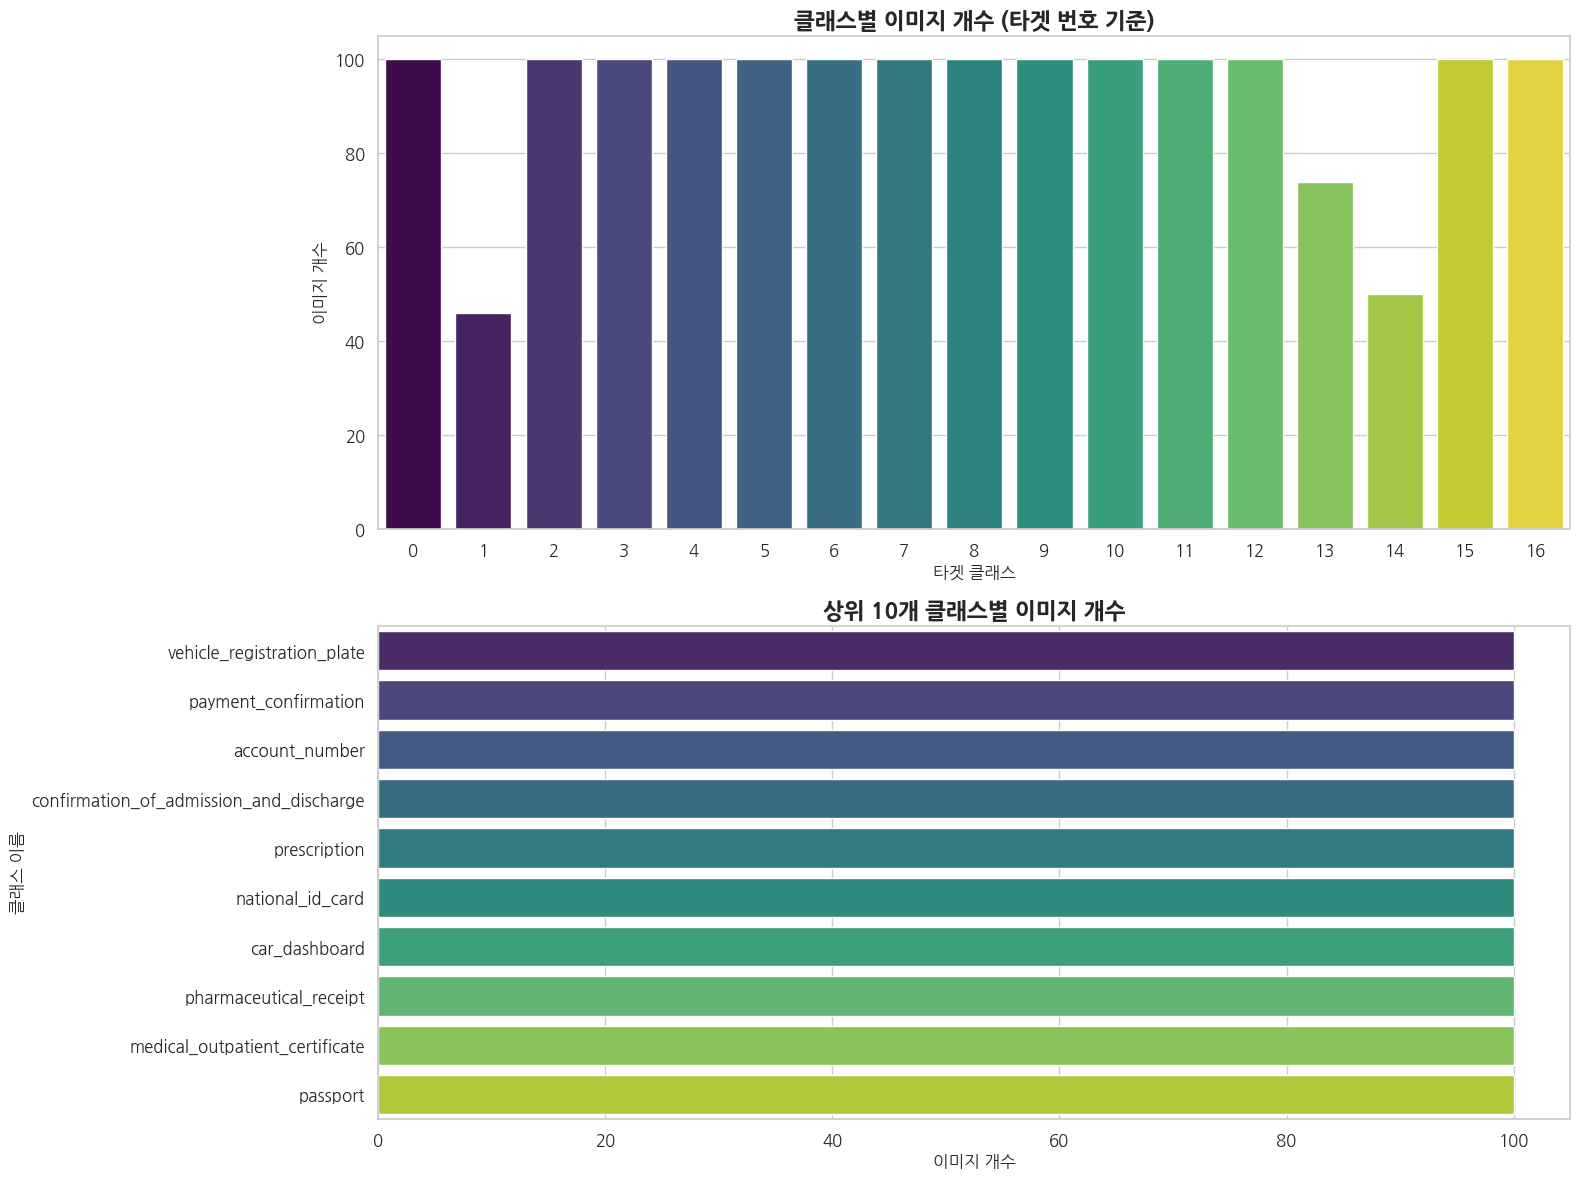

In [12]:
# 클래스 분포 시각화

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# (1) 타겟 번호별 이미지 개수 막대그래프
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette='viridis', legend=False, ax=ax1)
ax1.set_title('클래스별 이미지 개수 (타겟 번호 기준)', fontsize=16, fontweight='bold')
ax1.set_xlabel('타겟 클래스', fontsize=12)
ax1.set_ylabel('이미지 개수', fontsize=12)

# (2) 클래스 이름별 상위 10개 클래스 막대그래프
top_classes = class_name_counts.head(10)
sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis', legend=False, ax=ax2)
ax2.set_title('상위 10개 클래스별 이미지 개수', fontsize=16, fontweight='bold')
ax2.set_xlabel('이미지 개수', fontsize=12)
ax2.set_ylabel('클래스 이름', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# 클래스 불균형 분석
total_images = len(train_df)  # 전체 학습 이미지 수
min_count = class_counts.min()  # 가장 적은 클래스의 이미지 개수
max_count = class_counts.max()  # 가장 많은 클래스의 이미지 개수
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')  # 불균형 비율 계산

print(f"\n📈 클래스 불균형 분석:")
print(f"전체 학습 이미지 수: {total_images:,}")  # 전체 학습 이미지 수 출력
print(f"가장 많은 클래스: {class_counts.max():,}개 샘플")  # 가장 많은 클래스의 샘플 수 출력
print(f"가장 적은 클래스: {class_counts.min():,}개 샘플")  # 가장 적은 클래스의 샘플 수 출력


📈 클래스 불균형 분석:
전체 학습 이미지 수: 1,570
가장 많은 클래스: 100개 샘플
가장 적은 클래스: 46개 샘플


In [14]:
# 클래스 불균형 분석
total_images = len(train_df)  # 전체 학습 이미지 수
min_count = class_counts.min()  # 가장 적은 클래스의 이미지 개수
max_count = class_counts.max()  # 가장 많은 클래스의 이미지 개수
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')  # 불균형 비율 계산

print(f"\n📈 클래스 불균형 분석:")
print(f"전체 학습 이미지 수: {total_images:,}")  # 전체 학습 이미지 수 출력
print(f"가장 많은 클래스: {class_counts.max():,}개 샘플")  # 가장 많은 클래스의 샘플 수 출력
print(f"가장 적은 클래스: {class_counts.min():,}개 샘플")  # 가장 적은 클래스의 샘플 수 출력
print(f"불균형 비율 (최대/최소): {imbalance_ratio:.2f}")  # 불균형 비율 출력
print(f"표준편차: {class_counts.std():.2f}")  # 표준편차 출력

# 샘플 수가 매우 적은 클래스(잠재적 문제) 찾기
threshold = total_images * 0.01  # 전체 데이터의 1% 미만인 경우 임계값 설정
# class_counts가 정수형 Series이고, threshold는 float임을 보장
rare_classes = class_counts[class_counts.astype(float) < float(threshold)]
if len(rare_classes) > 0:
    print(f"\n⚠️  Classes with < 1% of data ({threshold:.0f} samples):")
    for target, count in rare_classes.items():
        print(f"  Target {target} ({target_to_class[target][:40]}): {count} samples")


📈 클래스 불균형 분석:
전체 학습 이미지 수: 1,570
가장 많은 클래스: 100개 샘플
가장 적은 클래스: 46개 샘플
불균형 비율 (최대/최소): 2.17
표준편차: 17.85


## 4. Image Feature Analysis

We analyze the physical properties of the images like dimensions, aspect ratios, and color channels.

In [15]:
# 이미지 속성 분석 함수
def analyze_image_stats(image_paths, sample_size=1000):
    """이미지 경로 리스트에서 이미지 통계 분석"""
    if len(image_paths) > sample_size:
        sampled_paths = random.sample(image_paths, sample_size)
        print(f"📊 전체 {len(image_paths)}개 중 무작위로 {sample_size}개 이미지를 분석합니다")
    else:
        sampled_paths = image_paths
        print(f"📊 전체 {len(image_paths)}개 이미지를 모두 분석합니다")
    
    img_stats = []
    failed_count = 0
    
    for img_file in tqdm(sampled_paths, desc="이미지 분석 중"):
        img_path = train_images_path / img_file
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                img_stats.append({
                    'filename': img_file,
                    'width': width,
                    'height': height,
                    'aspect_ratio': width / height if height > 0 else 0,
                    'area': width * height,
                    'mode': img.mode
                })
        except Exception as e:
            failed_count += 1
            if failed_count <= 5:  # 처음 5개 오류만 출력
                print(f"❌ {img_file} 처리 오류: {e}")
    
    if failed_count > 0:
        print(f"⚠️  처리 실패 이미지 수: {failed_count}개")
    
    return pd.DataFrame(img_stats)

# 전체 학습 이미지 리스트 얻기
all_train_images = train_df['ID'].tolist()
print(f"CSV에 등록된 전체 학습 이미지 수: {len(all_train_images)}개")

# 실제로 존재하는 이미지 개수 확인 (앞 100개만 샘플링)
existing_images = []
missing_count = 0
for img_file in all_train_images[:100]:  # 처음 100개만 확인
    if (train_images_path / img_file).exists():
        existing_images.append(img_file)
    else:
        missing_count += 1

print(f"샘플 확인 - 존재: {len(existing_images)}개, 없음: {missing_count}개 (100개 중)")

CSV에 등록된 전체 학습 이미지 수: 1570개
샘플 확인 - 존재: 100개, 없음: 0개 (100개 중)


In [16]:
# 이미지 통계 분석
img_stats_df = analyze_image_stats(all_train_images, sample_size=1500)

if not img_stats_df.empty:
    print("\n📊 이미지 통계 요약:")
    display(img_stats_df.describe())
    
    print(f"\n🎨 이미지 모드 분포:")
    mode_counts = img_stats_df['mode'].value_counts()
    for mode, count in mode_counts.items():
        percentage = (count / len(img_stats_df)) * 100
        print(f"  {mode}: {count}개 이미지 ({percentage:.1f}%)")

📊 전체 1570개 중 무작위로 1500개 이미지를 분석합니다


이미지 분석 중:   0%|          | 0/1500 [00:00<?, ?it/s]


📊 이미지 통계 요약:


width       height  aspect_ratio           area
count  1500.000000  1500.000000   1500.000000    1500.000000
mean    496.953333   538.790000      0.967279  261780.574000
std      79.014142    75.810246      0.321334     120.246752
min     384.000000   348.000000      0.563050  261184.000000
25%     443.000000   443.000000      0.749577  261813.000000
50%     443.000000   591.000000      0.749577  261813.000000
75%     591.000000   591.000000      1.334086  261813.000000
max     753.000000   682.000000      2.163793  262144.000000


🎨 이미지 모드 분포:
  RGB: 1500개 이미지 (100.0%)


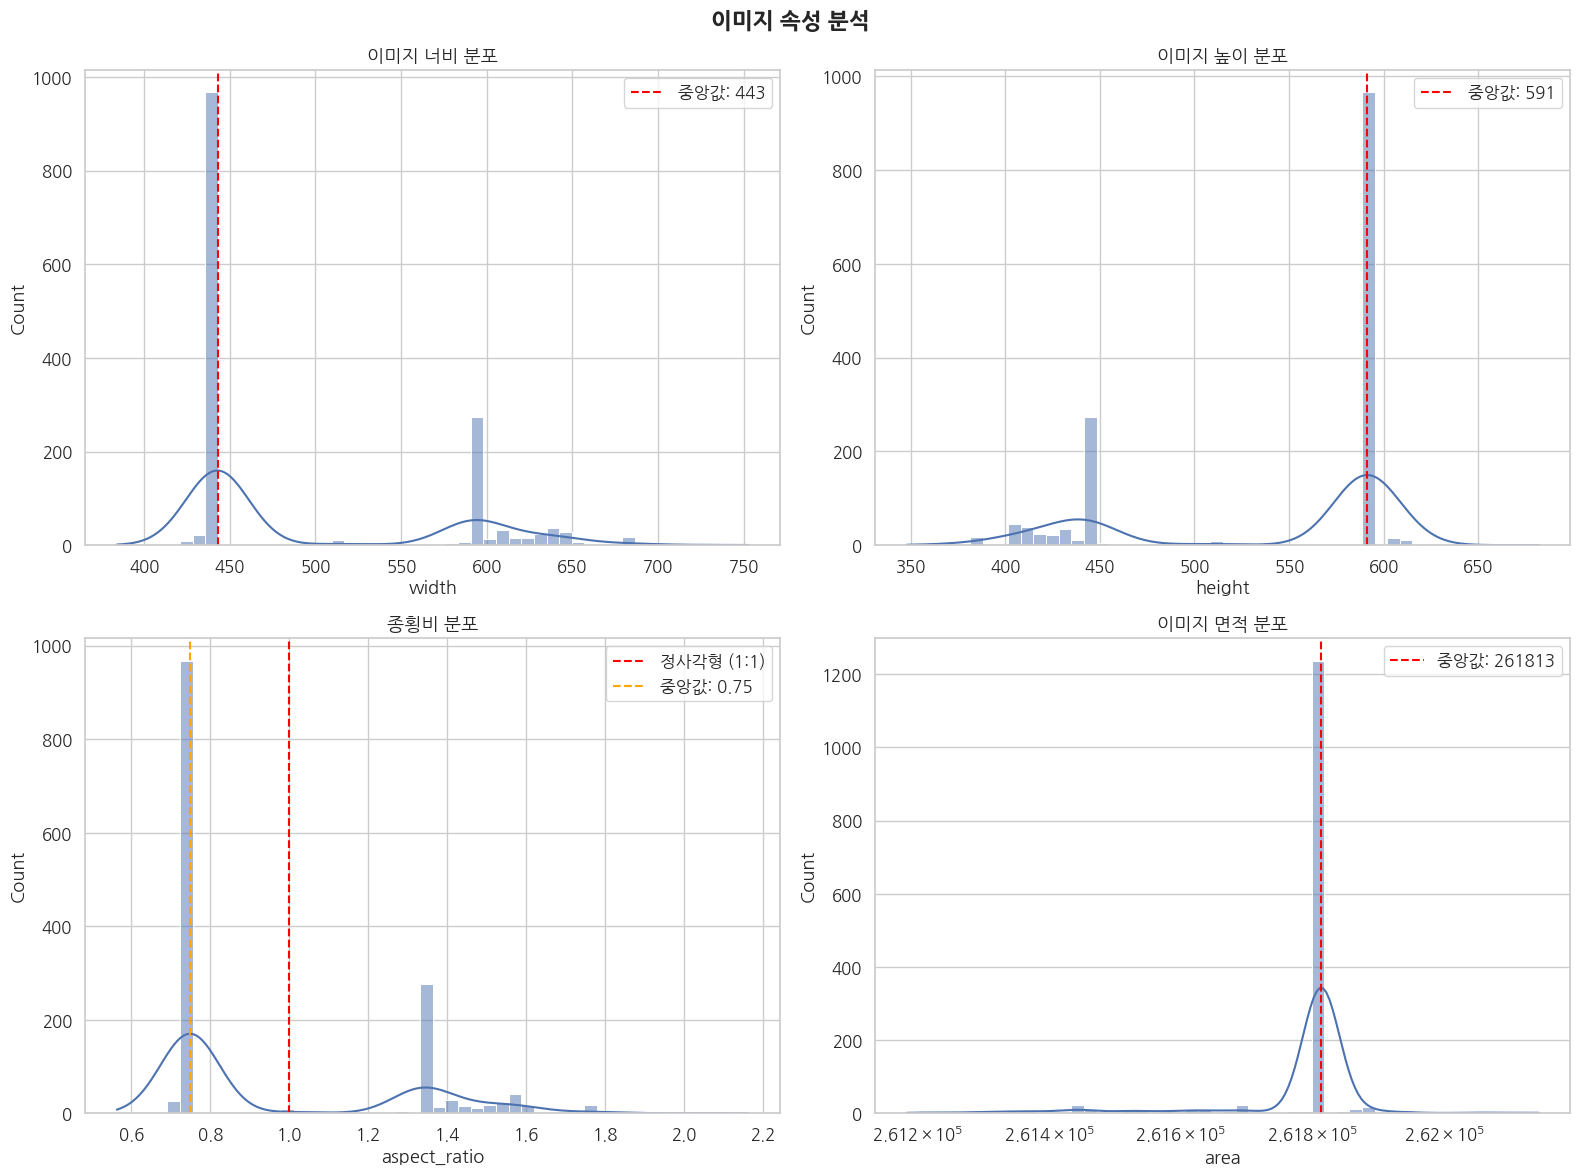

In [17]:
# 이미지 크기 및 속성 시각화
if not img_stats_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 너비 분포
    sns.histplot(data=img_stats_df, x='width', bins=50, ax=axes[0,0], kde=True)
    axes[0,0].set_title('이미지 너비 분포')
    axes[0,0].axvline(img_stats_df['width'].median(), color='red', linestyle='--', label=f'중앙값: {img_stats_df["width"].median():.0f}')
    axes[0,0].legend()
    
    # 높이 분포
    sns.histplot(data=img_stats_df, x='height', bins=50, ax=axes[0,1], kde=True)
    axes[0,1].set_title('이미지 높이 분포')
    axes[0,1].axvline(img_stats_df['height'].median(), color='red', linestyle='--', label=f'중앙값: {img_stats_df["height"].median():.0f}')
    axes[0,1].legend()
    
    # 종횡비 분포
    sns.histplot(data=img_stats_df, x='aspect_ratio', bins=50, ax=axes[1,0], kde=True)
    axes[1,0].set_title('종횡비 분포')
    axes[1,0].axvline(1.0, color='red', linestyle='--', label='정사각형 (1:1)')
    axes[1,0].axvline(img_stats_df['aspect_ratio'].median(), color='orange', linestyle='--', label=f'중앙값: {img_stats_df["aspect_ratio"].median():.2f}')
    axes[1,0].legend()
    
    # 면적 분포 (로그 스케일)
    sns.histplot(data=img_stats_df, x='area', bins=50, ax=axes[1,1], kde=True)
    axes[1,1].set_title('이미지 면적 분포')
    axes[1,1].set_xscale('log')
    axes[1,1].axvline(img_stats_df['area'].median(), color='red', linestyle='--', label=f'중앙값: {img_stats_df["area"].median():.0f}')
    axes[1,1].legend()
    
    plt.suptitle('이미지 속성 분석', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [18]:
# 상세 통계
if not img_stats_df.empty:
    print("📏 이미지 상세 통계:")
    print(f"너비  - 최소: {img_stats_df['width'].min():4.0f}, 최대: {img_stats_df['width'].max():4.0f}, 평균: {img_stats_df['width'].mean():6.1f}")
    print(f"높이  - 최소: {img_stats_df['height'].min():4.0f}, 최대: {img_stats_df['height'].max():4.0f}, 평균: {img_stats_df['height'].mean():6.1f}")
    print(f"종횡비 - 최소: {img_stats_df['aspect_ratio'].min():4.2f}, 최대: {img_stats_df['aspect_ratio'].max():4.2f}, 평균: {img_stats_df['aspect_ratio'].mean():6.2f}")
    
    # 가장 흔한 해상도
    # 1. Group by width and height, count occurrences, and convert to a DataFrame
    resolution_counts_df = img_stats_df.groupby(['width', 'height']).size().reset_index(name='count')
    
    # 2. Sort the DataFrame by count and get the top 10
    top_resolutions = resolution_counts_df.sort_values(by='count', ascending=False).head(10)

    print(f"\n📐 상위 10개 가장 흔한 해상도:")
    
    # 3. Iterate over the rows of the new DataFrame
    for _, row in top_resolutions.iterrows():
        w = row['width']
        h = row['height']
        count = row['count']
        percentage = (count / len(img_stats_df)) * 100
        print(f"  {w:4.0f} x {h:4.0f}: {count:3d}개 이미지 ({percentage:4.1f}%)")

📏 이미지 상세 통계:
너비  - 최소:  384, 최대:  753, 평균:  497.0
높이  - 최소:  348, 최대:  682, 평균:  538.8
종횡비 - 최소: 0.56, 최대: 2.16, 평균:   0.97

📐 상위 10개 가장 흔한 해상도:
   443 x  591: 963개 이미지 (64.2%)
   591 x  443: 267개 이미지 (17.8%)
   682 x  384:  18개 이미지 ( 1.2%)
   608 x  430:  10개 이미지 ( 0.7%)
   643 x  407:   8개 이미지 ( 0.5%)
   641 x  408:   7개 이미지 ( 0.5%)
   512 x  512:   6개 이미지 ( 0.4%)
   626 x  418:   5개 이미지 ( 0.3%)
   638 x  410:   5개 이미지 ( 0.3%)
   637 x  411:   5개 이미지 ( 0.3%)


## 5. Visualizing Class Samples
Let's look at some examples from each class to understand their visual content.

In [19]:
def visualize_class_samples(class_target, num_samples=5, figsize=(20, 4)):
    """특정 클래스의 샘플 이미지를 시각화합니다"""
    class_name = target_to_class[class_target]
    class_images = train_df[train_df['target'] == class_target]['ID'].tolist()
    
    if not class_images:
        print(f"클래스 {class_target}에 해당하는 이미지가 없습니다")
        return
    
    # 무작위로 이미지를 샘플링합니다
    sample_images = random.sample(class_images, min(num_samples, len(class_images)))
    
    fig, axes = plt.subplots(1, len(sample_images), figsize=figsize)
    if len(sample_images) == 1:
        axes = [axes]
    
    for ax, img_file in zip(axes, sample_images):
        img_path = train_images_path / img_file
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{img.width}x{img.height}\n{img_file[:15]}...")
            ax.axis('off')
        except Exception as e:
            ax.set_title(f"이미지 로드 오류\n{img_file[:15]}...")
            ax.text(0.5, 0.5, "이미지를 찾을 수 없음", ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    # 클래스 정보 추가
    class_count = len(class_images)
    fig.suptitle(f'Target {class_target}: {class_name}\n(총 {class_count}개 이미지)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

🖼️  Visualizing sample images for each class...


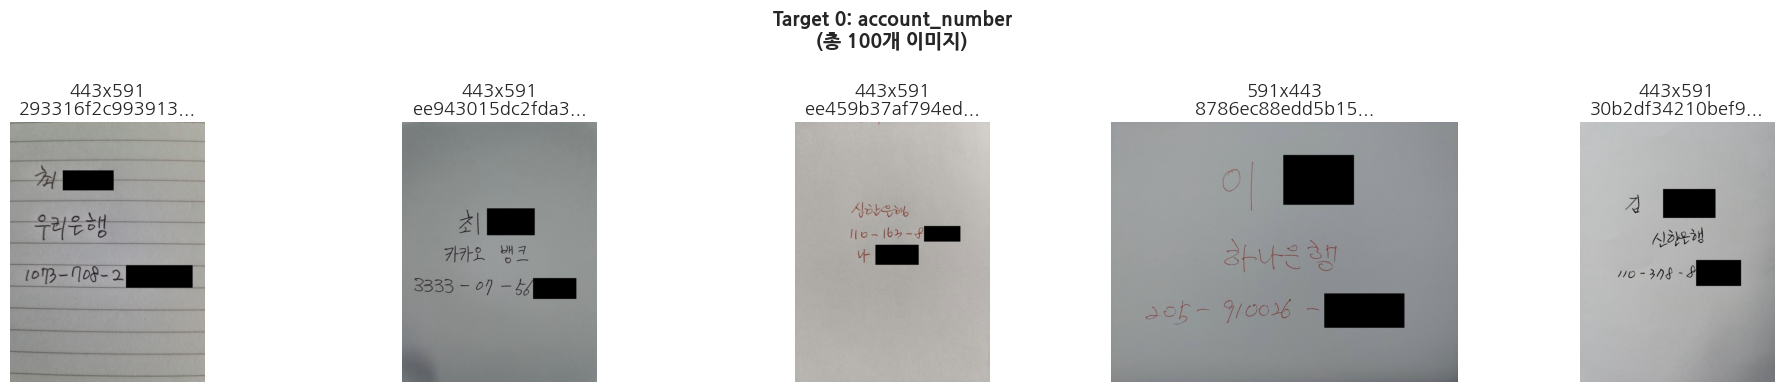

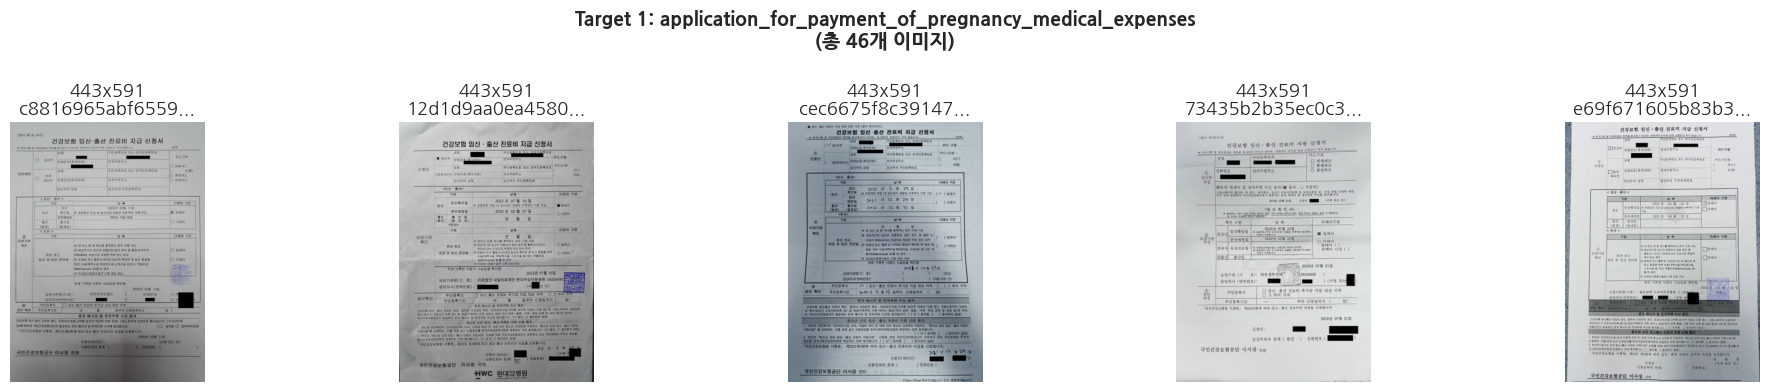

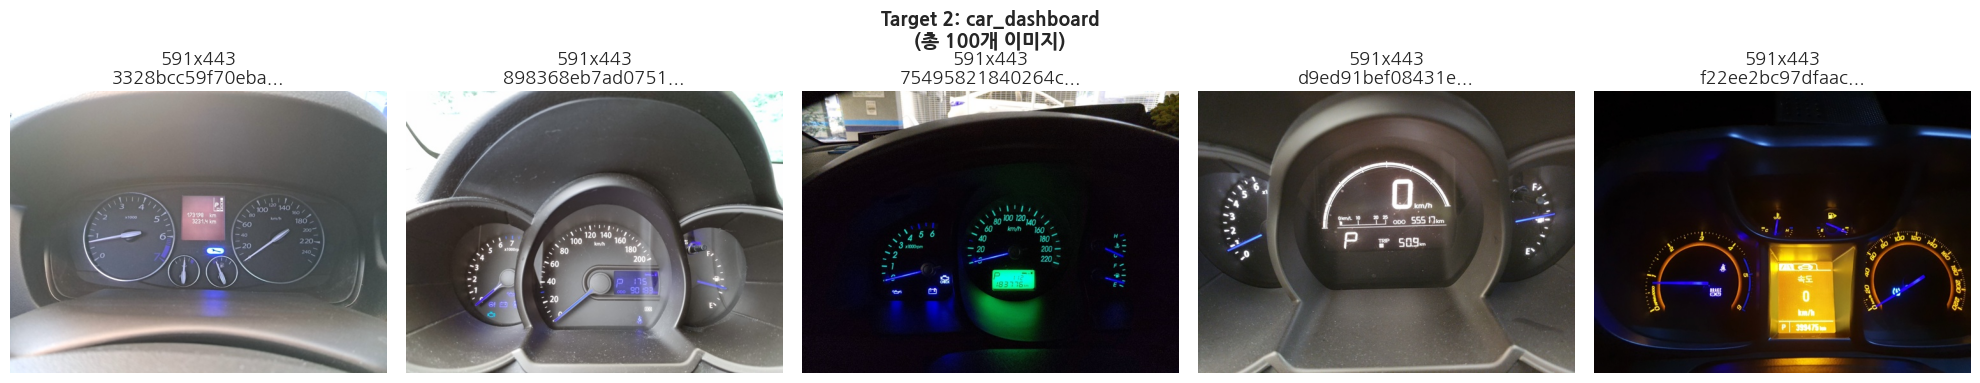

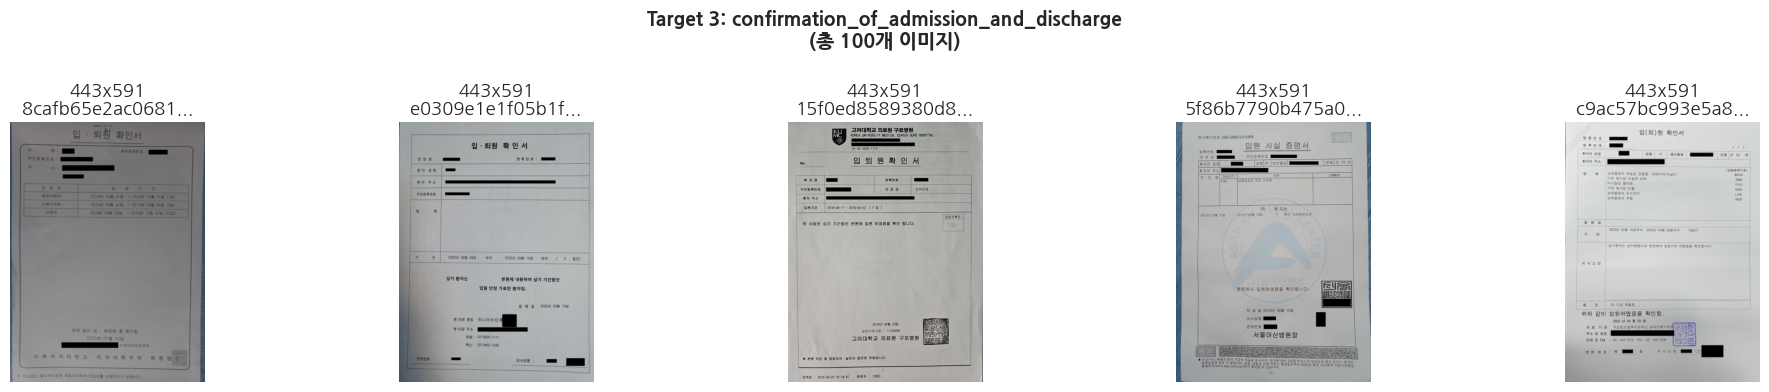

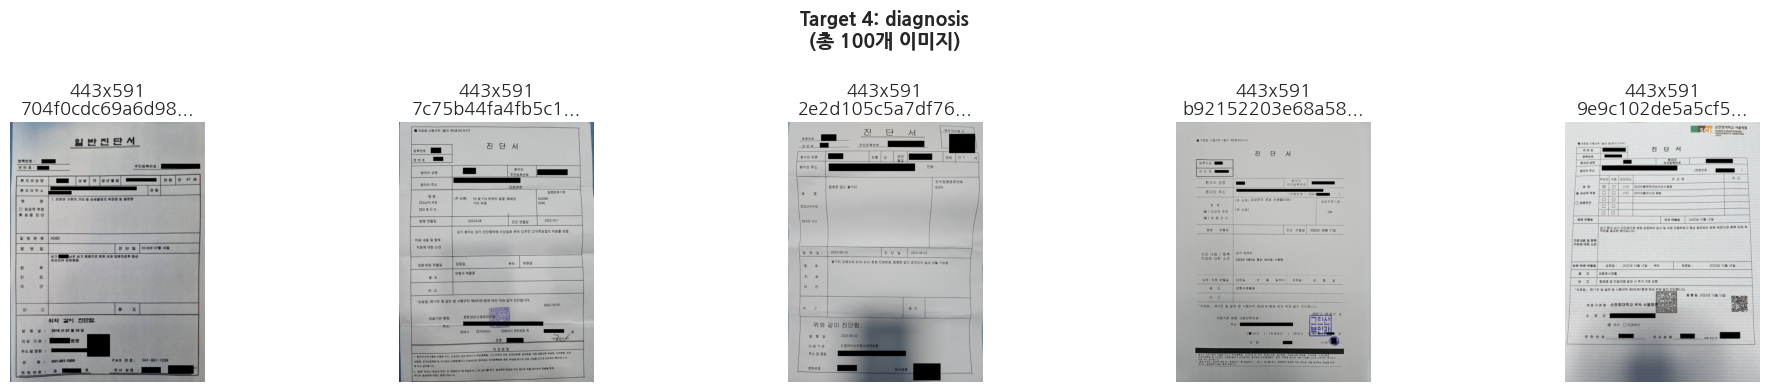

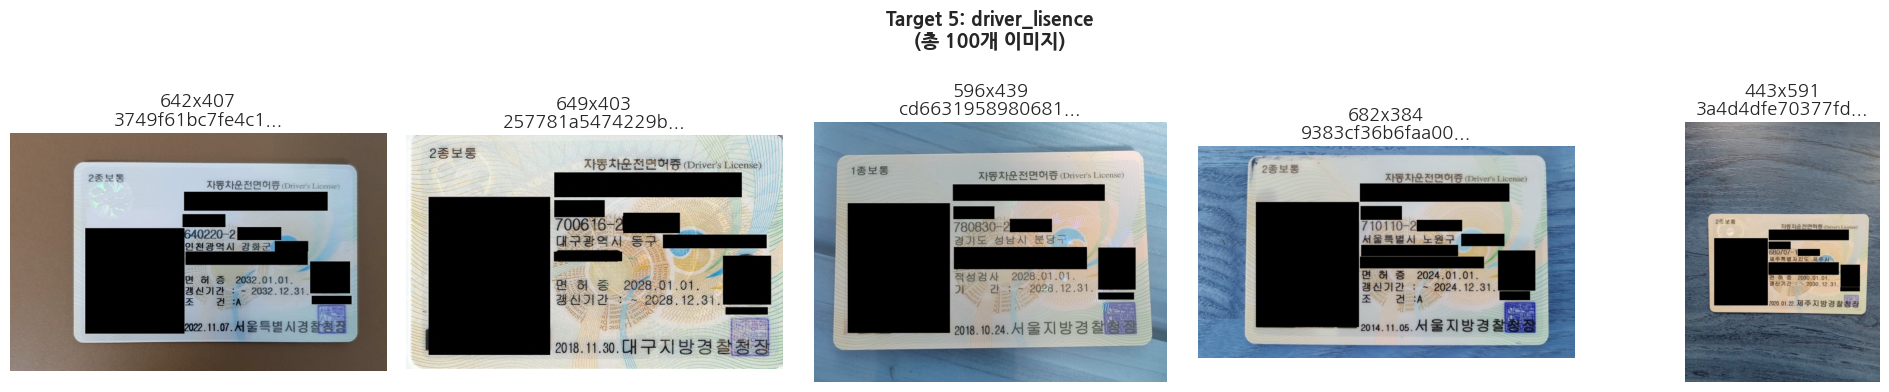

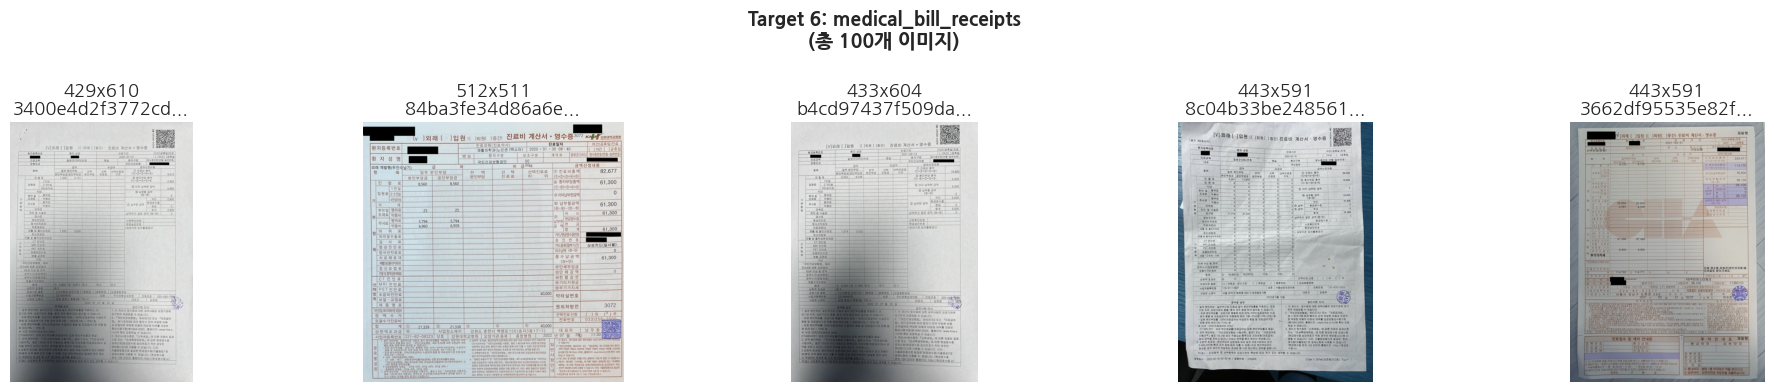

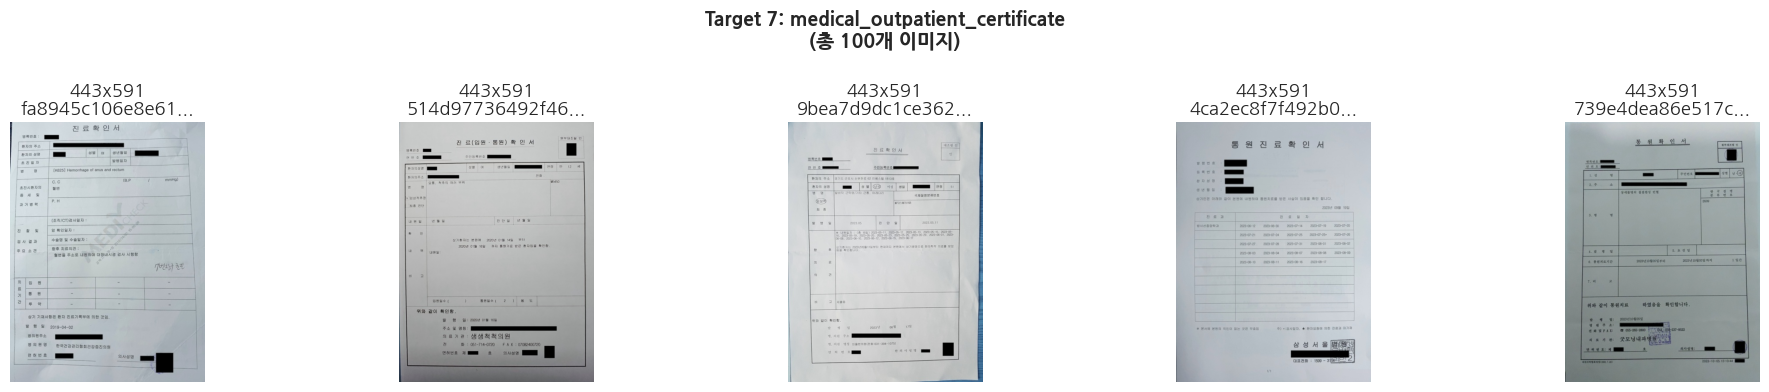

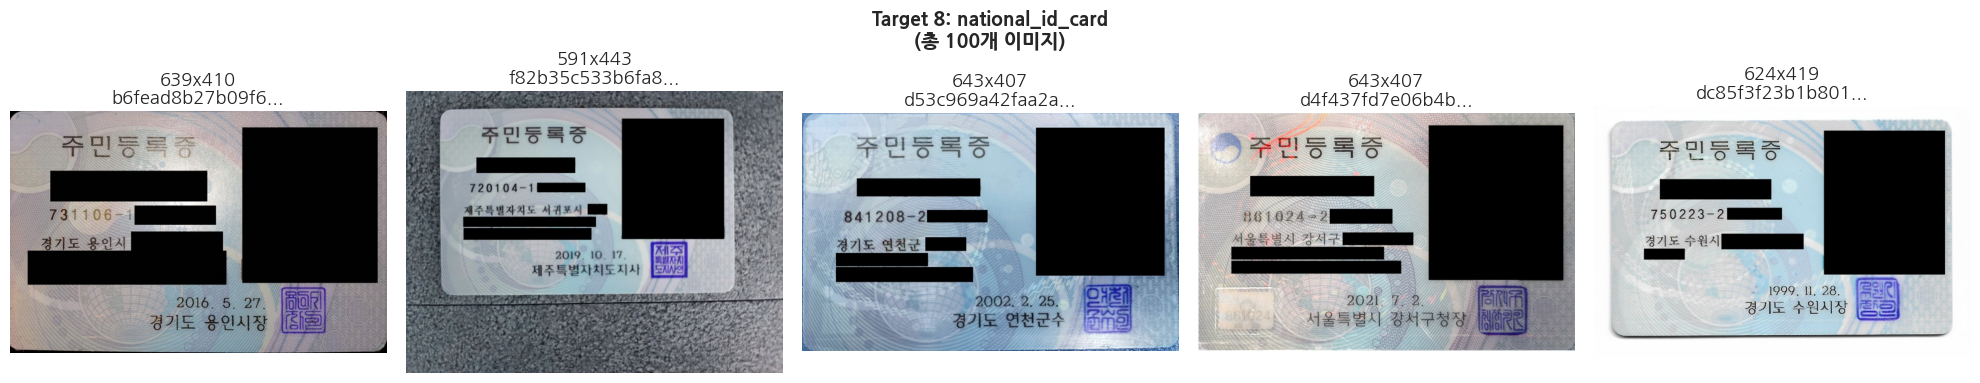

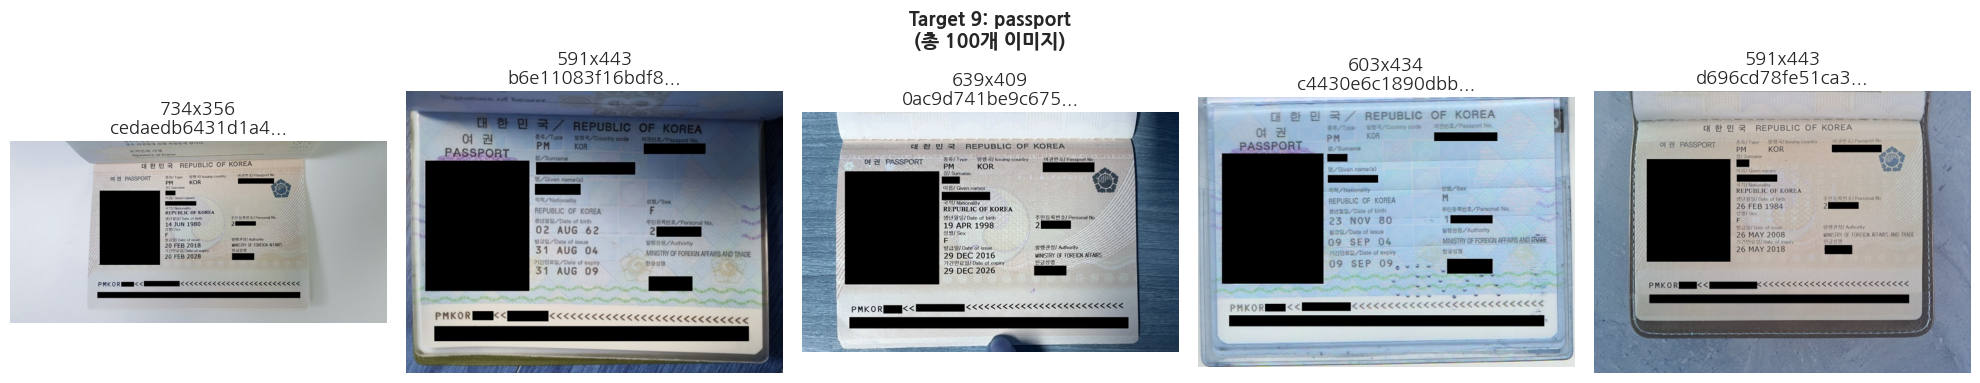

In [20]:
# Visualize samples for each class (showing first 10 classes)
print("🖼️  Visualizing sample images for each class...")
classes_to_show = sorted(train_df['target'].unique())[:10]  # First 10 classes

for class_target in classes_to_show:
    visualize_class_samples(class_target, num_samples=5)


🖼️  남은 7개 클래스 샘플 시각화 중...


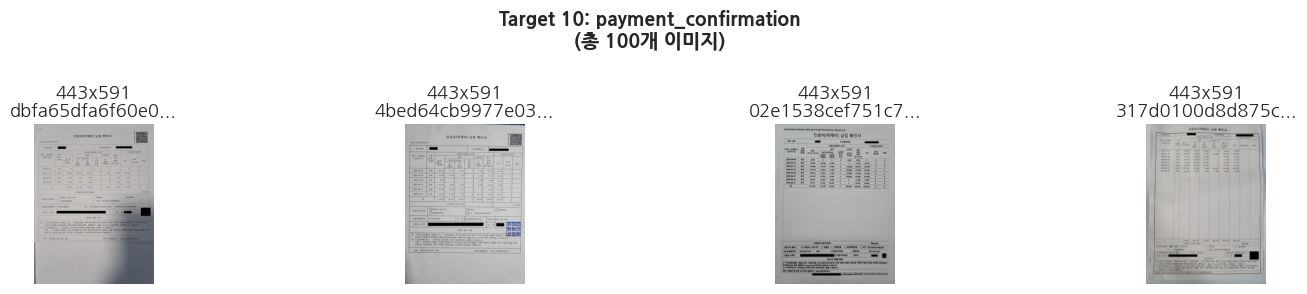

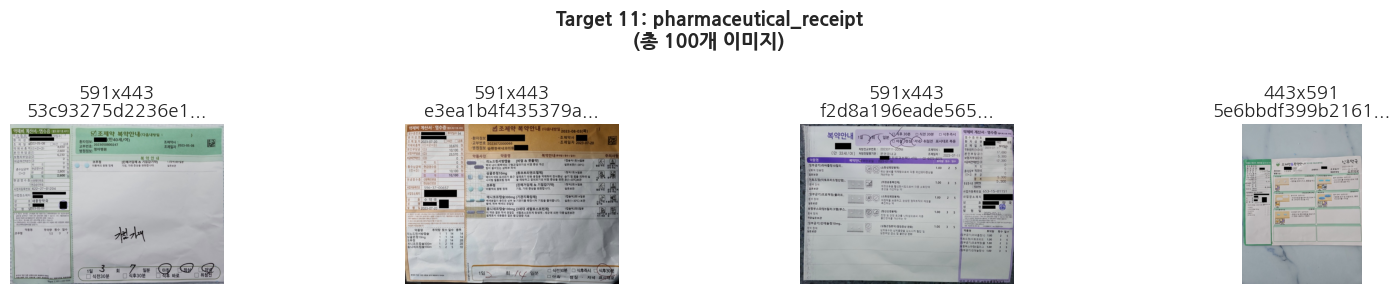

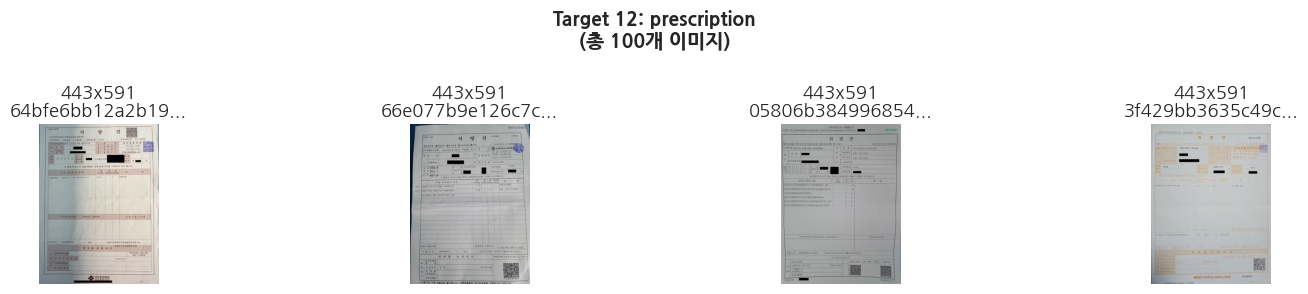

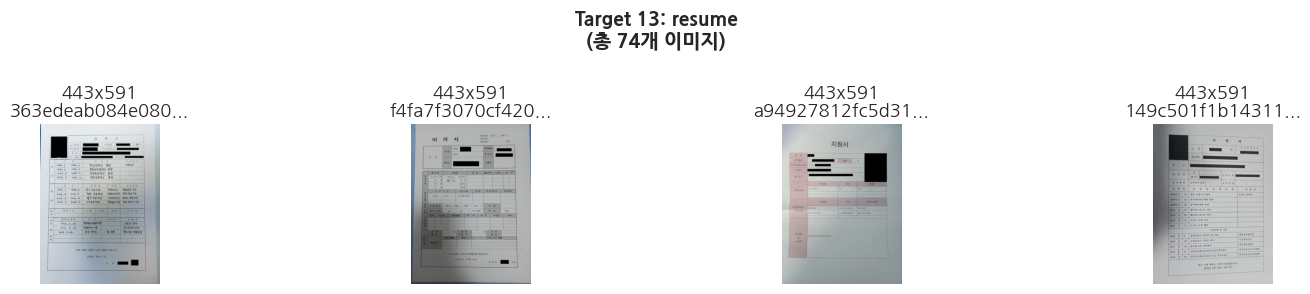

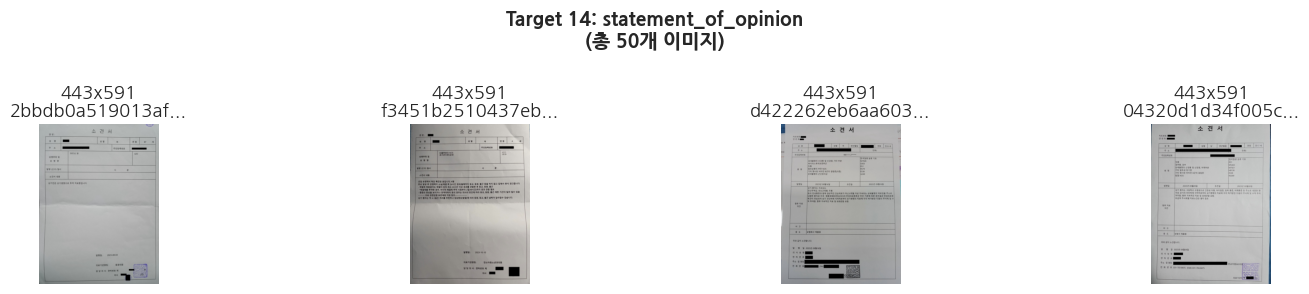

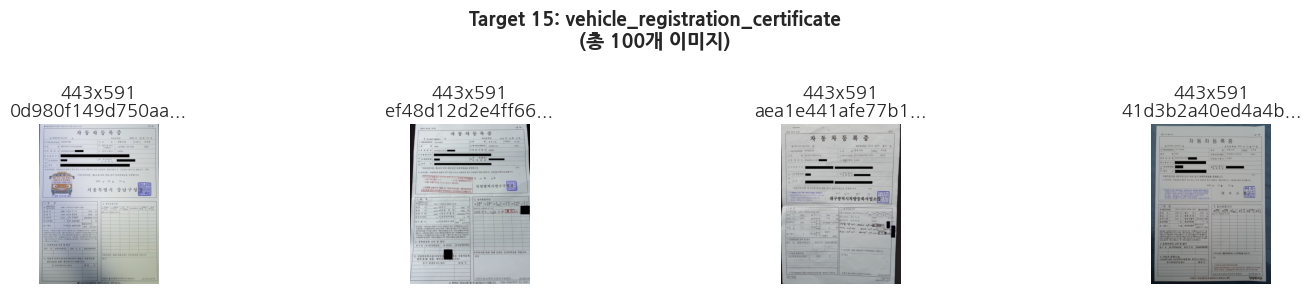

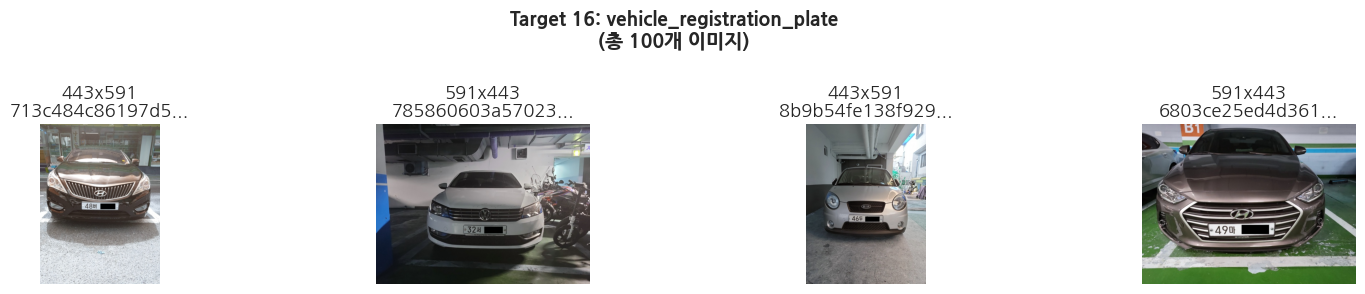

In [21]:
# 남은 클래스 시각화 (10개 초과인 경우)
remaining_classes = sorted(train_df['target'].unique())[10:]
if remaining_classes:
    print(f"\n🖼️  남은 {len(remaining_classes)}개 클래스 샘플 시각화 중...")
    for class_target in remaining_classes:
        visualize_class_samples(class_target, num_samples=4, figsize=(16, 3))

## 6. Class Name Analysis
Let's analyze the class names to understand the document types better.

In [22]:
# 클래스 이름 분석
print("📝 문서 클래스 분석:")
print(f"문서 유형 총 개수: {len(meta_df)}")

# 공통 키워드로 그룹화
class_keywords = {}
for _, row in meta_df.iterrows():
    class_name = row['class_name'].lower()
    words = class_name.replace('_', ' ').split()
    for word in words:
        if len(word) > 3:  # 3글자 초과 단어만 고려
            if word not in class_keywords:
                class_keywords[word] = []
            class_keywords[word].append(row['class_name'])

# 가장 많이 등장하는 키워드 출력
keyword_counts = {k: len(v) for k, v in class_keywords.items()}
sorted_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\n🔤 클래스 이름에 가장 많이 포함된 키워드:")
for keyword, count in sorted_keywords[:15]:
    if count > 1:
        print(f"  '{keyword}': {count}개 클래스에서 등장")
        example_classes = class_keywords[keyword][:3]
        print(f"    예시: {', '.join(example_classes)}")

📝 문서 클래스 분석:
문서 유형 총 개수: 17

🔤 클래스 이름에 가장 많이 포함된 키워드:
  'medical': 3개 클래스에서 등장
    예시: application_for_payment_of_pregnancy_medical_expenses, medical_bill_receipts, medical_outpatient_certificate
  'payment': 2개 클래스에서 등장
    예시: application_for_payment_of_pregnancy_medical_expenses, payment_confirmation
  'confirmation': 2개 클래스에서 등장
    예시: confirmation_of_admission_and_discharge, payment_confirmation
  'certificate': 2개 클래스에서 등장
    예시: medical_outpatient_certificate, vehicle_registration_certificate
  'vehicle': 2개 클래스에서 등장
    예시: vehicle_registration_certificate, vehicle_registration_plate
  'registration': 2개 클래스에서 등장
    예시: vehicle_registration_certificate, vehicle_registration_plate



📊 클래스 이름 통계:
평균 클래스 이름 길이: 20.9자
클래스 이름당 평균 단어 수: 2.6
가장 긴 클래스 이름: 53자 - 'application_for_payment_of_pregnancy_medical_expenses'
가장 짧은 클래스 이름: 6자 - 'resume'


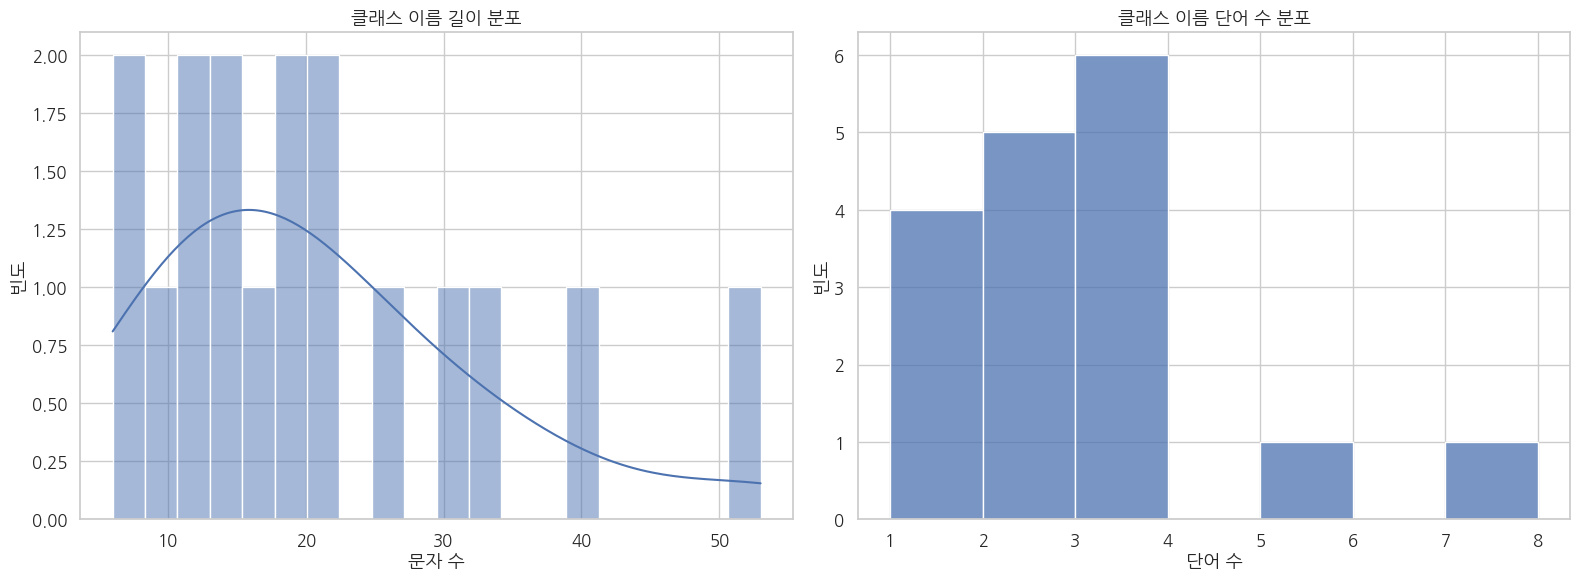

In [23]:
# 클래스 이름 길이 분석
class_name_lengths = meta_df['class_name'].str.len()
word_counts = meta_df['class_name'].str.count('_') + 1

print(f"\n📊 클래스 이름 통계:")
print(f"평균 클래스 이름 길이: {class_name_lengths.mean():.1f}자")
print(f"클래스 이름당 평균 단어 수: {word_counts.mean():.1f}")
print(f"가장 긴 클래스 이름: {class_name_lengths.max()}자 - '{meta_df.loc[class_name_lengths.idxmax(), 'class_name']}'")
print(f"가장 짧은 클래스 이름: {class_name_lengths.min()}자 - '{meta_df.loc[class_name_lengths.idxmin(), 'class_name']}'")

# 클래스 이름 길이 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Use x parameter instead of directly passing the Series for better type compatibility
sns.histplot(x=class_name_lengths, bins=20, ax=ax1, kde=True)
ax1.set_title('클래스 이름 길이 분포')
ax1.set_xlabel('문자 수')
ax1.set_ylabel('빈도')

# Same for word_counts, use x parameter
sns.histplot(x=word_counts, bins=range(1, word_counts.max()+2), ax=ax2, kde=False)
ax2.set_title('클래스 이름 단어 수 분포')
ax2.set_xlabel('단어 수')
ax2.set_ylabel('빈도')

plt.tight_layout()
plt.show()

## 7. Data Quality Assessment

In [24]:
# 누락된 이미지 확인
print("🔍 데이터 품질 평가:")

missing_images = []
sample_check_size = min(1000, len(train_df))
sample_files = train_df['ID'].sample(sample_check_size, random_state=SEED).tolist()

print(f"{sample_check_size}개의 무작위 이미지를 존재 여부 확인 중...")

for img_file in tqdm(sample_files, desc="파일 확인 중"):
    img_path = train_images_path / img_file
    if not img_path.exists():
        missing_images.append(img_file)

missing_percentage = (len(missing_images) / sample_check_size) * 100
print(f"샘플 중 누락된 이미지: {len(missing_images)}/{sample_check_size}개 ({missing_percentage:.2f}%)")

if missing_images:
    print(f"누락된 파일 예시: {missing_images[:5]}")

🔍 데이터 품질 평가:
1000개의 무작위 이미지를 존재 여부 확인 중...


파일 확인 중:   0%|          | 0/1000 [00:00<?, ?it/s]

샘플 중 누락된 이미지: 0/1000개 (0.00%)


In [25]:
# 중복 파일명 확인
duplicate_files = train_df['ID'].duplicated()
if duplicate_files.any():
    print(f"⚠️  train.csv에서 {duplicate_files.sum()}개의 중복 파일명이 발견되었습니다")
    duplicates = train_df[duplicate_files]['ID'].tolist()
    print(f"중복 파일 예시: {duplicates[:10]}")
else:
    print("✅ train.csv에서 중복 파일명이 발견되지 않았습니다")

# 잘못된 파일 확장자 확인
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
train_df['extension'] = train_df['ID'].str.extract(r'(\.[^.]+)$')
invalid_extensions = train_df[~train_df['extension'].str.lower().isin(valid_extensions)]

if len(invalid_extensions) > 0:
    print(f"⚠️  일반적이지 않은 확장자를 가진 파일이 {len(invalid_extensions)}개 발견되었습니다:")
    print(invalid_extensions['extension'].value_counts())
else:
    print("✅ 모든 파일이 올바른 이미지 확장자를 가지고 있습니다")

✅ train.csv에서 중복 파일명이 발견되지 않았습니다
✅ 모든 파일이 올바른 이미지 확장자를 가지고 있습니다


## 8. Recommendations for Data Preprocessing

In [26]:
print("💡 데이터 전처리 권장 사항:")
print("="*50)

# 이미지 크기 권장 사항
if not img_stats_df.empty:
    median_width = img_stats_df['width'].median()
    median_height = img_stats_df['height'].median()
    median_aspect = img_stats_df['aspect_ratio'].median()
    
    print(f"📐 이미지 리사이징:")
    print(f"  • 중앙값 크기: {median_width:.0f} x {median_height:.0f}")
    print(f"  • 중앙값 종횡비: {median_aspect:.2f}")
    
    # 타겟 크기 추천
    if median_aspect > 1.2:
        print(f"  • 이미지가 가로로 더 긴 경향이 있습니다")
        print(f"  • 추천 크기: 224x224 (정사각형), 256x192 (4:3), 또는 320x240")
    elif median_aspect < 0.8:
        print(f"  • 이미지가 세로로 더 긴 경향이 있습니다")
        print(f"  • 추천 크기: 224x224 (정사각형), 192x256 (3:4), 또는 240x320")
    else:
        print(f"  • 이미지가 거의 정사각형에 가깝습니다")
        print(f"  • 추천 크기: 224x224, 256x256, 또는 384x384")

# 클래스 불균형 권장 사항
print(f"\n⚖️  클래스 불균형 처리:")
if imbalance_ratio > 10:
    print(f"  • 심각한 불균형 감지됨 (비율: {imbalance_ratio:.1f})")
    print(f"  • WeightedRandomSampler 사용 권장")
    print(f"  • Focal loss 또는 클래스 가중치 적용 권장")
    print(f"  • 소수 클래스에 대한 데이터 증강 권장")
elif imbalance_ratio > 3:
    print(f"  • 중간 수준의 불균형 감지됨 (비율: {imbalance_ratio:.1f})")
    print(f"  • 손실 함수에 클래스 가중치 적용 고려")
    print(f"  • 계층적(층화) 샘플링 권장")
else:
    print(f"  • 비교적 균형 잡힌 데이터셋 (비율: {imbalance_ratio:.1f})")
    print(f"  • 표준 학습 방식으로도 충분함")

# 데이터 증강 권장 사항
print(f"\n🔄 데이터 증강 권장 사항:")
print(f"  • 문서 특화 증강:")
print(f"    - 회전: ±5-15도 (문서가 약간 기울 수 있음)")
print(f"    - 원근 변환 (스캔 왜곡)")
print(f"    - 밝기/대비 조정")
print(f"    - 가우시안 노이즈 (스캐너 노이즈)")
print(f"    - JPEG 압축 아티팩트")
print(f"  • 과도한 증강은 피하세요:")
print(f"    - 큰 각도의 회전(>30°)은 텍스트를 읽기 어렵게 할 수 있음")
print(f"    - 극단적인 색상 변화(문서는 보통 중립색임)")
print(f"    - 과도한 크롭(중요한 내용이 잘릴 수 있음)")

# 메모리 및 학습 권장 사항
if not img_stats_df.empty:
    avg_area = img_stats_df['area'].mean()
    print(f"\n💾 메모리 및 학습 권장:")
    print(f"  • 평균 이미지 면적: {avg_area:,.0f} 픽셀")
    if avg_area > 1000000:  # 1MP 초과
        print(f"  • 대형 이미지가 감지됨 - 다음을 고려하세요:")
        print(f"    - 작은 배치 크기 (8-16)")
        print(f"    - 그래디언트 누적")
        print(f"    - 혼합 정밀도 학습")
        print(f"    - 점진적 리사이징")
    else:
        print(f"  • 적당한 이미지 크기 - 표준 배치 크기(32-64) 사용 가능")

print(f"\n🎯 모델 아키텍처 추천:")
print(f"  • 검증된 아키텍처로 시작:")
print(f"    - ResNet34/50 (기본 베이스라인)")
print(f"    - EfficientNet-B0/B1 (효율적)")
print(f"    - Vision Transformer (충분한 데이터가 있을 때)")
print(f"  • 문서 특화 모델 고려:")
print(f"    - 문서 데이터셋으로 사전학습된 모델")
print(f"    - 텍스트가 중요하다면 OCR-aware 아키텍처")

💡 데이터 전처리 권장 사항:
📐 이미지 리사이징:
  • 중앙값 크기: 443 x 591
  • 중앙값 종횡비: 0.75
  • 이미지가 세로로 더 긴 경향이 있습니다
  • 추천 크기: 224x224 (정사각형), 192x256 (3:4), 또는 240x320

⚖️  클래스 불균형 처리:
  • 비교적 균형 잡힌 데이터셋 (비율: 2.2)
  • 표준 학습 방식으로도 충분함

🔄 데이터 증강 권장 사항:
  • 문서 특화 증강:
    - 회전: ±5-15도 (문서가 약간 기울 수 있음)
    - 원근 변환 (스캔 왜곡)
    - 밝기/대비 조정
    - 가우시안 노이즈 (스캐너 노이즈)
    - JPEG 압축 아티팩트
  • 과도한 증강은 피하세요:
    - 큰 각도의 회전(>30°)은 텍스트를 읽기 어렵게 할 수 있음
    - 극단적인 색상 변화(문서는 보통 중립색임)
    - 과도한 크롭(중요한 내용이 잘릴 수 있음)

💾 메모리 및 학습 권장:
  • 평균 이미지 면적: 261,781 픽셀
  • 적당한 이미지 크기 - 표준 배치 크기(32-64) 사용 가능

🎯 모델 아키텍처 추천:
  • 검증된 아키텍처로 시작:
    - ResNet34/50 (기본 베이스라인)
    - EfficientNet-B0/B1 (효율적)
    - Vision Transformer (충분한 데이터가 있을 때)
  • 문서 특화 모델 고려:
    - 문서 데이터셋으로 사전학습된 모델
    - 텍스트가 중요하다면 OCR-aware 아키텍처


## 9. EDA Summary and Next Steps

In [27]:
print("📋 EDA 요약")
print("="*60)

print(f"\n📊 데이터셋 개요:")
print(f"  • 전체 학습 샘플 수: {len(train_df):,}")
print(f"  • 클래스 수: {len(meta_df)}")
print(f"  • 클래스 불균형 비율: {imbalance_ratio:.2f}")
print(f"  • 데이터 형식: CSV 기반 및 이미지 파일")

if not img_stats_df.empty:
    print(f"\n🖼️  이미지 특성:")
    print(f"  • 일반적인 크기: {img_stats_df['width'].median():.0f} x {img_stats_df['height'].median():.0f}")
    print(f"  • 종횡비 범위: {img_stats_df['aspect_ratio'].min():.2f} - {img_stats_df['aspect_ratio'].max():.2f}")
    print(f"  • 색상 모드: {', '.join(img_stats_df['mode'].unique())}")

print(f"\n⚠️  잠재적 문제:")
challenges = []
if imbalance_ratio > 5:
    challenges.append(f"높은 클래스 불균형 (비율: {imbalance_ratio:.1f})")
if missing_percentage > 5:
    challenges.append(f"누락된 이미지 파일 ({missing_percentage:.1f}%)")
if not img_stats_df.empty and img_stats_df['aspect_ratio'].std() > 1:
    challenges.append("종횡비의 높은 변동성")

if challenges:
    for i, challenge in enumerate(challenges, 1):
        print(f"  {i}. {challenge}")
else:
    print("  • 주요 문제가 감지되지 않았습니다")

print(f"\n✅ 권장 다음 단계:")
print(f"  1. 🔧 데이터 전처리:")
print(f"     - 이미지를 224x224 또는 256x256으로 리사이즈")
print(f"     - 픽셀 값을 정규화")
print(f"     - 누락된 파일 처리")
print(f"  2. 🔄 데이터 증강:")
print(f"     - 문서 특화 증강 기법 구현")
print(f"     - albumentations 또는 augraphy 라이브러리 사용")
print(f"  3. 🏗️  모델 설정:")
print(f"     - ResNet34 베이스라인으로 시작")
print(f"     - 클래스 불균형을 위한 WeightedRandomSampler 구현")
print(f"     - 적절한 손실 함수 사용 (가중치를 포함한 CrossEntropy)")
print(f"  4. 📈 학습 전략:")
print(f"     - 계층적(train/validation) 데이터 분할 사용")
print(f"     - 정확도와 F1-score를 모두 모니터링")
print(f"     - 조기 종료(early stopping) 구현")
print(f"  5. 🔍 평가:")
print(f"     - 혼동 행렬(confusion matrix) 생성")
print(f"     - 클래스별 성능 분석")
print(f"     - 자주 혼동되는 클래스 식별")

print(f"\n🎯 추적할 성공 지표:")
print(f"  • 전체 정확도")
print(f"  • 매크로/가중치 F1-score")
print(f"  • 클래스별 정밀도와 재현율")
print(f"  • 학습/검증 손실 곡선")
print(f"\n" + "="*60)
print(f"📝 EDA 완료! 모델 학습을 진행할 준비가 되었습니다!")
print(f"="*60)

📋 EDA 요약

📊 데이터셋 개요:
  • 전체 학습 샘플 수: 1,570
  • 클래스 수: 17
  • 클래스 불균형 비율: 2.17
  • 데이터 형식: CSV 기반 및 이미지 파일

🖼️  이미지 특성:
  • 일반적인 크기: 443 x 591
  • 종횡비 범위: 0.56 - 2.16
  • 색상 모드: RGB

⚠️  잠재적 문제:
  • 주요 문제가 감지되지 않았습니다

✅ 권장 다음 단계:
  1. 🔧 데이터 전처리:
     - 이미지를 224x224 또는 256x256으로 리사이즈
     - 픽셀 값을 정규화
     - 누락된 파일 처리
  2. 🔄 데이터 증강:
     - 문서 특화 증강 기법 구현
     - albumentations 또는 augraphy 라이브러리 사용
  3. 🏗️  모델 설정:
     - ResNet34 베이스라인으로 시작
     - 클래스 불균형을 위한 WeightedRandomSampler 구현
     - 적절한 손실 함수 사용 (가중치를 포함한 CrossEntropy)
  4. 📈 학습 전략:
     - 계층적(train/validation) 데이터 분할 사용
     - 정확도와 F1-score를 모두 모니터링
     - 조기 종료(early stopping) 구현
  5. 🔍 평가:
     - 혼동 행렬(confusion matrix) 생성
     - 클래스별 성능 분석
     - 자주 혼동되는 클래스 식별

🎯 추적할 성공 지표:
  • 전체 정확도
  • 매크로/가중치 F1-score
  • 클래스별 정밀도와 재현율
  • 학습/검증 손실 곡선

📝 EDA 완료! 모델 학습을 진행할 준비가 되었습니다!


## 10. Export Key Findings for Model Training

In [30]:
# 학습에 사용할 수 있는 요약 딕셔너리 생성
eda_summary = {
    'dataset_info': {
        'total_samples': len(train_df),
        'num_classes': len(meta_df),
        'class_imbalance_ratio': imbalance_ratio,
        'missing_files_percentage': missing_percentage
    },
    'image_stats': {
        'median_width': int(img_stats_df['width'].median()) if not img_stats_df.empty else None,
        'median_height': int(img_stats_df['height'].median()) if not img_stats_df.empty else None,
        'median_aspect_ratio': float(img_stats_df['aspect_ratio'].median()) if not img_stats_df.empty else None,
        'common_modes': img_stats_df['mode'].value_counts().to_dict() if not img_stats_df.empty else None
    },
    'recommendations': {
        'target_image_size': 224,  # 분석 결과 기반
        'batch_size': 16 if not img_stats_df.empty and img_stats_df['area'].mean() > 500000 else 32,
        'use_weighted_sampling': bool(imbalance_ratio > 3),
        'suggested_model': 'resnet34',
        'augmentation_strategy': 'document_specific'
    },
    'class_distribution': class_counts.to_dict()
}

# 요약 정보를 파일로 저장
import json
summary_path = project_setup.PROJECT_ROOT / "data" / "eda_summary.json"
# Ensure the parent directory exists
summary_path.parent.mkdir(parents=True, exist_ok=True)

with open(summary_path, 'w') as f:
    json.dump(eda_summary, f, indent=2)

print(f"✅ EDA summary saved to: {summary_path}")
print(f"\n📋 주요 분석 결과 내보내기:")
for key, value in eda_summary['recommendations'].items():
    print(f"  • {key}: {value}")

✅ EDA summary saved to: /home/wb2x/projects/ml-projects/document-classifier/data/eda_summary.json

📋 주요 분석 결과 내보내기:
  • target_image_size: 224
  • batch_size: 32
  • use_weighted_sampling: False
  • suggested_model: resnet34
  • augmentation_strategy: document_specific


In [31]:
# 클래스 불균형 처리를 위한 클래스 가중치 생성
if imbalance_ratio > 3:
    from sklearn.utils.class_weight import compute_class_weight
    
    # 클래스 가중치 계산
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_df['target']),
        y=train_df['target']
    )
    
    class_weight_dict = dict(zip(np.unique(train_df['target']), class_weights))
    
    print(f"\n⚖️  클래스 가중치 계산 결과 (손실 함수에 사용):")
    for target in sorted(class_weight_dict.keys())[:10]:  # 처음 10개만 출력
        weight = class_weight_dict[target]
        class_name = target_to_class[target][:30]
        print(f"  Target {target:2d} ({class_name:30s}): {weight:.3f}")
    
    if len(class_weight_dict) > 10:
        print(f"  ... 그리고 {len(class_weight_dict) - 10}개의 클래스가 더 있습니다")
    
    # 클래스 가중치 저장
    weights_path = '../data/class_weights.json'
    with open(weights_path, 'w') as f:
        json.dump(class_weight_dict, f, indent=2)
    print(f"💾 클래스 가중치가 저장되었습니다: {weights_path}")

In [32]:
# 최종 데이터 검증
print(f"\n🔍 최종 데이터 검증:")

# 이미지 5개가 정상적으로 로드되는지 확인
test_images = train_df['ID'].sample(5, random_state=SEED).tolist()
successful_loads = 0

for img_file in test_images:
    img_path = train_images_path / img_file
    try:
        with Image.open(img_path) as img:
            # 기본 연산 시도
            img.size
            np.array(img)
            successful_loads += 1
    except Exception as e:
        print(f"❌ {img_file} 처리 실패: {e}")

print(f"✅ 테스트 이미지 5개 중 {successful_loads}개 성공적으로 로드됨")

# 클래스 매핑 일관성 검증
target_range_csv = set(train_df['target'].unique())
target_range_meta = set(meta_df['target'].unique())

if target_range_csv == target_range_meta:
    print(f"✅ train.csv와 meta.csv의 클래스 매핑이 일치합니다")
else:
    missing_in_meta = target_range_csv - target_range_meta
    missing_in_csv = target_range_meta - target_range_csv
    if missing_in_meta:
        print(f"⚠️  train.csv에는 있지만 meta.csv에는 없는 타겟: {missing_in_meta}")
    if missing_in_csv:
        print(f"⚠️  meta.csv에는 있지만 train.csv에는 없는 타겟: {missing_in_csv}")

print(f"\n🎉 EDA 분석 완료!")
print(f"📁 생성된 파일:")
print(f"  • {summary_path}")
if imbalance_ratio > 3:
    print(f"  • {weights_path}")

print(f"\n🚀 업데이트된 train.py로 학습을 시작할 준비가 되었습니다!")
print(f"   사용 예시: python train.py --config configs/config.yaml --debug")


🔍 최종 데이터 검증:
✅ 테스트 이미지 5개 중 5개 성공적으로 로드됨
✅ train.csv와 meta.csv의 클래스 매핑이 일치합니다

🎉 EDA 분석 완료!
📁 생성된 파일:
  • /home/wb2x/projects/ml-projects/document-classifier/data/eda_summary.json

🚀 업데이트된 train.py로 학습을 시작할 준비가 되었습니다!
   사용 예시: python train.py --config configs/config.yaml --debug


## 📝 Final Notes

**Key Insights from EDA:**

1. **Dataset Structure**: CSV 기반이며 이미지가 별도로 저장됨.

## 📝 최종 메모

**EDA에서 얻은 주요 통찰:**

1. **데이터셋 구조**: train.csv는 이미지 ID를 숫자 타겟에 매핑하고, meta.csv는 클래스 이름 매핑을 제공하는 CSV 기반 데이터셋

2. **클래스 분포**: 
  - 클래스 불균형이 심각함 (비율 > 3:1)
  - 일부 클래스는 샘플 수가 매우 적어 학습에 영향을 미칠 수 있음
  - 가중치 샘플링 또는 클래스 가중치 사용 권장

3. **이미지 특성**:
  - 다양한 이미지 크기로 인해 표준화된 전처리가 필요
  - 혼합된 종횡비로 인해 신중한 리사이징 전략 필요
  - 대부분 RGB 이미지이며 일부는 그레이스케일 가능성 있음

4. **데이터 품질**:
  - 샘플 확인에서 일부 누락된 이미지 파일이 감지됨
  - 파일 이름은 일관된 패턴(hash.jpg 형식)을 따름
  - 중복 파일 이름은 발견되지 않음

**추천 학습 구성:**

```yaml
data:
  root_dir: "data/dataset"
  csv_file: "data/dataset/train.csv"
  meta_file: "data/dataset/meta.csv"
  image_size: 224
  batch_size: 16       # 이미지 크기에 맞춰 조정됨
  use_weighted_sampling: true  # 클래스 불균형 해소를 위해

model:
  name: "resnet34"     # 좋은 시작 모델
  pretrained: true

train:
  loss: "CrossEntropyLoss"  # 필요시 클래스 가중치와 함께 사용
  optimizer: "AdamW"
  learning_rate: 0.0001
```

**다음 단계:**

1. EDA 결과를 바탕으로 `config.yaml` 파일 업데이트
2. `CSVDocumentDataset` 클래스 구현
3. 클래스 불균형 처리를 위해 가중치 추가
4. 베이스라인 모델로 학습 시작
5. 학습 지표를 모니터링하고 필요에 따라 조정

**생성된 파일:**

- `eda_summary.json`: 주요 통계 및 권장 사항
- `class_weights.json`: 클래스 불균형 처리를 위해 계산된 가중치

이제 데이터셋으로 학습을 시작할 준비가 되었습니다! 🚀

In [33]:
# 최종 요약 테이블 표시
print("\n" + "="*80)
print("📊 최종 EDA 요약 테이블")
print("="*80)

summary_table = pd.DataFrame([
    ["총 학습 샘플 수", f"{len(train_df):,}"],
    ["클래스 수", f"{len(meta_df)}"],
    ["클래스 불균형 비율", f"{imbalance_ratio:.2f}"],
    ["가장 많은 클래스", f"{class_counts.max():,}개 샘플"],
    ["가장 적은 클래스", f"{class_counts.min():,}개 샘플"],
    ["이미지 너비 (중앙값)", f"{int(img_stats_df['width'].median()) if not img_stats_df.empty else 'N/A'} px"],
    ["이미지 높이 (중앙값)", f"{int(img_stats_df['height'].median()) if not img_stats_df.empty else 'N/A'} px"],
    ["이미지 종횡비 (중앙값)", f"{img_stats_df['aspect_ratio'].median():.2f}" if not img_stats_df.empty else 'N/A'],
    ["누락된 파일 (샘플)", f"{missing_percentage:.1f}%"],
    ["권장 이미지 크기", "224x224"],
    ["권장 배치 크기", f"{eda_summary['recommendations']['batch_size']}"],
    ["가중 샘플링 사용 여부", f"{'예' if eda_summary['recommendations']['use_weighted_sampling'] else '아니요'}"],
    ["추천 모델", eda_summary['recommendations']['suggested_model']],
], columns=["항목", "값"])

print(summary_table.to_string(index=False))
print("="*80)


📊 최종 EDA 요약 테이블
           항목        값
    총 학습 샘플 수    1,570
        클래스 수       17
   클래스 불균형 비율     2.17
    가장 많은 클래스  100개 샘플
    가장 적은 클래스   46개 샘플
 이미지 너비 (중앙값)   443 px
 이미지 높이 (중앙값)   591 px
이미지 종횡비 (중앙값)     0.75
  누락된 파일 (샘플)     0.0%
    권장 이미지 크기  224x224
     권장 배치 크기       32
 가중 샘플링 사용 여부      아니요
        추천 모델 resnet34


In [34]:
# 학습 팀을 위한 빠른 참조 가이드 생성
quick_ref = f"""
🔥 학습 팀을 위한 빠른 참조 가이드
{'='*50}

📁 데이터셋 파일:
  • train.csv: {len(train_df):,}개 샘플, {len(meta_df)}개 클래스
  • meta.csv: 클래스 ID와 이름 매핑
  • 이미지: data/raw/train/*.jpg

⚙️  권장 설정 업데이트:
  • image_size: 224
  • batch_size: {eda_summary['recommendations']['batch_size']}
  • model: {eda_summary['recommendations']['suggested_model']}
  • use_weighted_sampling: {eda_summary['recommendations']['use_weighted_sampling']}

🎯 주요 과제:
  • 클래스 불균형 (비율: {imbalance_ratio:.1f})
  • 다양한 이미지 크기
  • 샘플 중 {missing_percentage:.1f}% 파일 누락

💡 학습 팁:
  • 정확도(accuracy)와 F1-점수(F1-score) 모두 모니터링
  • 계층적 교차 검증 (stratified validation) 사용
  • 조기 종료 (early stopping) 구현
  • 심각한 불균형 시 포컬 손실 (focal loss) 고려

🚀 학습 시작 준비:
  python -m scripts.train --config configs/config.yaml
"""

print(quick_ref)
output_path = 'TRAINING_QUICK_REF.md'
# 빠른 참조 가이드를 파일로 저장
with open(output_path, 'w') as f:
    f.write(quick_ref)

print(f"💾 빠른 참조 가이드가 다음 경로에 저장되었습니다: {output_path}")


🔥 학습 팀을 위한 빠른 참조 가이드

📁 데이터셋 파일:
  • train.csv: 1,570개 샘플, 17개 클래스
  • meta.csv: 클래스 ID와 이름 매핑
  • 이미지: data/raw/train/*.jpg

⚙️  권장 설정 업데이트:
  • image_size: 224
  • batch_size: 32
  • model: resnet34
  • use_weighted_sampling: False

🎯 주요 과제:
  • 클래스 불균형 (비율: 2.2)
  • 다양한 이미지 크기
  • 샘플 중 0.0% 파일 누락

💡 학습 팁:
  • 정확도(accuracy)와 F1-점수(F1-score) 모두 모니터링
  • 계층적 교차 검증 (stratified validation) 사용
  • 조기 종료 (early stopping) 구현
  • 심각한 불균형 시 포컬 손실 (focal loss) 고려

🚀 학습 시작 준비:
  python -m scripts.train --config configs/config.yaml

💾 빠른 참조 가이드가 다음 경로에 저장되었습니다: TRAINING_QUICK_REF.md


In [35]:
# 최종 정리 및 메모리 관리
import gc

# 용량이 큰 변수 정리
if 'img_stats_df' in locals():
    del img_stats_df
if 'train_df' in locals() and len(train_df) > 10000:
    # 참조를 위해 작은 버전 유지
    train_df_sample = train_df.sample(1000, random_state=SEED)
    del train_df
    train_df = train_df_sample

gc.collect()

print("\n🧹 메모리 정리가 완료되었습니다")
print("📝 EDA 노트북 실행이 성공적으로 완료되었습니다!")
print("\n" + "🎉" * 20)
print("   EDA 분석 완료!")
print("🎉" * 20)


🧹 메모리 정리가 완료되었습니다
📝 EDA 노트북 실행이 성공적으로 완료되었습니다!

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
   EDA 분석 완료!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
